In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lqns-dict-batch-1/LQNS_dict_batch_1.dat
/kaggle/input/lq0-dict-batch-1/LQ0_dict_batch_1.dat


In [71]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from scipy.stats import moment, kurtosis, skew
import time
from tqdm import tqdm

In [72]:
data_path = '/kaggle/input/lq0-dict-batch-1/LQ0_dict_batch_1.dat'
with open(data_path, "rb") as pf:
    Data = pickle.load(pf)
    
data_path_2 = '/kaggle/input/lqns-dict-batch-1/LQNS_dict_batch_1.dat'
with open(data_path_2, "rb") as pf:
    Data2 = pickle.load(pf)

In [73]:
Dcts = []
Dcts.append(Data)
#Dcts.append(Data2)

In [74]:
def load(Dct, Nuc, cent, charge, Ncurve=1000):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"]
    Yfin = Dct[Nuc][cent][charge]["FINAL"]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin

In [75]:
def load_sample(Dct, Nuc, cent, charge, Ncurve=2000):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"][:Ncurve]
    Yfin = Dct[Nuc][cent][charge]["FINAL"][:Ncurve]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin

In [76]:
Xin_Ru = Data['Ru']['INITIAL_eta']
Xfin_Ru = Data['Ru']['FINAL_eta']

Xin_Zr = Data['Zr']['INITIAL_eta']
Xfin_Zr = Data['Zr']['FINAL_eta']

ON FULL DATA

In [77]:
import numpy as np

# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin = []
all_Yfin = []
all_Xin = []
all_Xfin = []
all_Nuc = []
all_cent = []
all_charge = []

for Data in Dcts:
    # Iterate through the dictionary
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                        # Load Xin, Yin, Xfin, Yfin using the load function
                        Xin, Yin, Xfin, Yfin = load(Data, Nuc, cent, charge)
                        # Append to the lists along with identifiers
                        all_Yin.append(Yin)
                        all_Yfin.append(Yfin)
                        all_Xin.append(Xin)
                        all_Xfin.append(Xfin)
                        all_Nuc.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                        all_cent.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                        all_charge.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_full = np.concatenate(all_Yin, axis=0)  # Assuming concatenation is appropriate
all_Yfin_full = np.concatenate(all_Yfin, axis=0)
all_Nuc_full = np.array(all_Nuc)
all_cent_full = np.array(all_cent)
all_charge_full = np.array(all_charge)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_full.shape)
print("Shape of all_Yfin:", all_Yfin_full.shape)
print("Shape of all_Nuc:", all_Nuc_full.shape)
print("Shape of all_cent:", all_cent_full.shape)
print("Shape of all_charge:", all_charge_full.shape)

from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_full = nuc_one_hot_encoder.fit_transform(all_Nuc_full.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_full = charge_one_hot_encoder.fit_transform(all_charge_full.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_full = cent_one_hot_encoder.fit_transform(all_cent_full.reshape(-1, 1))

# Concatenate features
X_features = np.concatenate([all_Yin_full, all_Nuc_encoded_full, all_charge_encoded_full], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1, all_cent_train_1, all_cent_test_1, all_charge_train_1, all_charge_test_1 = train_test_split(
    X_features, all_Yfin_full, all_cent_encoded_full, all_charge_encoded_full, test_size=0.2, random_state=42, shuffle = True)


Shape of all_Yin: (158592, 72)
Shape of all_Yfin: (158592, 141)
Shape of all_Nuc: (158592,)
Shape of all_cent: (158592,)
Shape of all_charge: (158592,)


In [78]:
def calculate_moments_cumulants(data):
    mean = np.mean(data)
    variance = np.var(data)
    third_moment = np.mean((data - mean) ** 3)
    fourth_moment = np.mean((data - mean) ** 4)
    
    moments = {
        'mean': mean,
        'variance': variance,
        'third_moment': third_moment,
        'fourth_moment': fourth_moment
    }
    
    cumulants = {
        'mean': mean,
        'variance': variance,
        'third_cumulant': third_moment ,
        'fourth_cumulant': fourth_moment - 3 * ((variance) ** 2)
    }
    
    return moments, cumulants

In [79]:
def finetune(model, X_train, y_train, X_test, y_test, flag=False, scale = False):
    start_time = time.time()
    # Initialize tqdm to track iterations
    #progress_bar = tqdm(total=model.max_iter, desc="Training", position=0)
    
    # Create a StandardScaler instance
    if scale == True:
        scaler = StandardScaler()

        # Fit the scaler to the 'all_Yin' feature in the training data and transform it
        all_Yin_train_scaled = scaler.fit_transform(X_train[:, :72]) 

        # Use the same scaler to transform the 'all_Yin' feature in the test data
        all_Yin_test_scaled = scaler.transform(X_test[:, :72])  

        # Concatenate scaled 'all_Yin' with the encoded categorical features
        X_train = np.concatenate([all_Yin_train_scaled, X_train[:, 72:]], axis=1)
        X_test = np.concatenate([all_Yin_test_scaled, X_test[:, 72:]], axis=1)
    if flag:
        # Train the model using only the first 72 features
        model.fit(X_train[:, :72], y_train)
        # Predict on test data using only the first 72 features
        y_pred = model.predict(X_test[:, :72])
    else:
        # Train the model on all features
        model.fit(X_train, y_train)
        # Predict on test data using all features
        y_pred = model.predict(X_test)
    
    #progress_bar.close()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Example plot (adjust as per your specific data and visualization needs)
    sample_index = np.random.randint(1, len(X_test))
    y1_plot = X_test[sample_index, :72]  # First 72 features are all_Yin
    y1 = X_test[sample_index]
    y2 = y_test[sample_index]  # Corresponding y_test value

    # Example x-axis values
    if y1[-2] == 0.0:
        xaxes1 = Xin_Ru
        xaxes2 = Xfin_Ru
    else:
        xaxes1 = Xin_Zr
        xaxes2 = Xfin_Zr

    if flag:
        y1 = y1[:72]
        y2_pred = model.predict([y1])[0]
    else:
        y2_pred = model.predict([y1])[0]

    # Plotting
    plt.plot(xaxes1, y1_plot, 'r', label='Initial')
    plt.plot(xaxes2, y2, 'b', label='Final')
    plt.plot(xaxes2, y2_pred, 'k', label='Predicted')
    plt.legend()
    plt.xlabel('X-axis label')  # Replace with your actual x-axis label
    plt.ylabel('Y-axis label')  # Replace with your actual y-axis label
    plt.show()


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for histograms
def plot_histograms(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels

    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)

    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred = model.predict([y1])

                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.mean(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.mean(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)
                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 0.5 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)


In [33]:
lr = LinearRegression()
#finetune(lr, X_train_1, y_train_1, X_test_1, y_test_1, flag = True)

Training completed in 1.91 seconds.
Mean Squared Error: 0.5518136422999361


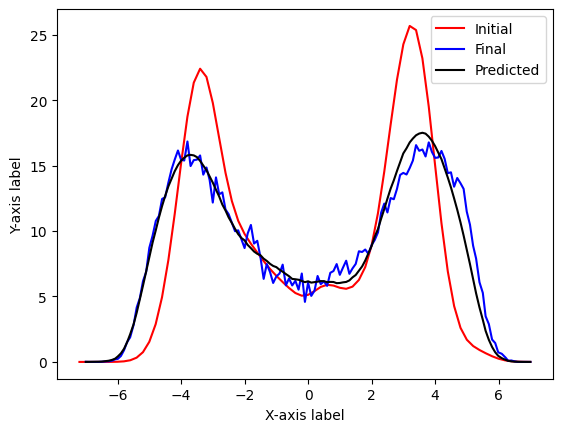

In [34]:
lr2 = LinearRegression()
finetune(lr2, X_train_1, y_train_1, X_test_1, y_test_1)

In [37]:
from sklearn.linear_model import Lasso

# Example usage with Lasso regression
lasso_model = Lasso(alpha = 1) 
#finetune(lasso_model, X_train_1, y_train_1, X_test_1, y_test_1)

In [ ]:
mlp_0 = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
finetune(mlp_0, X_train_1, y_train_1, X_test_1, y_test_1)

In [ ]:
mlp2 = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=42)
finetune(mlp2, X_train_1, y_train_1, X_test_1, y_test_1)

In [ ]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=5.0)  
finetune(ridge_model, X_train_1, y_train_1, X_test_1, y_test_1)

In [ ]:
# Example of varying parameters
mlp2 = MLPRegressor(
    hidden_layer_sizes=(200, 200), 
    max_iter=1000,                  
    solver='adam',                  
    learning_rate_init=0.001,       
    alpha=0.0001,                   
    batch_size=32,                  
    early_stopping=True,            
    validation_fraction=0.2,        
    random_state=42
)

finetune(mlp2, X_train_1, y_train_1, X_test_1, y_test_1)

0
actual 1909
pred 1909
1
actual 1823
pred 1823


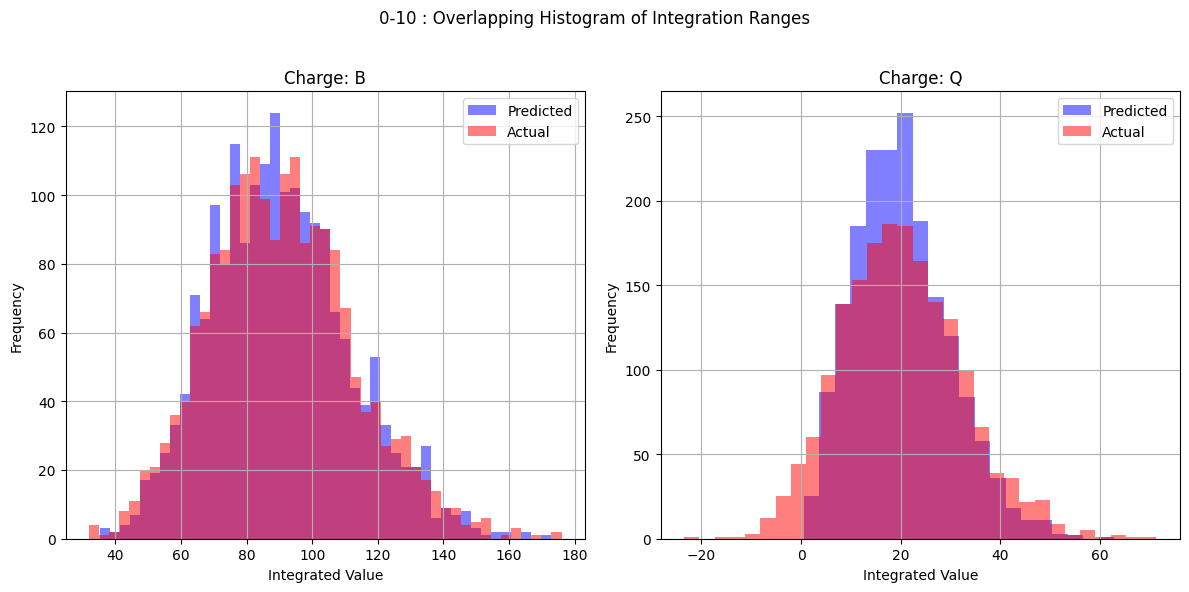

X_test: 31719
Check: 3732
0
actual 1949
pred 1949
1
actual 1960
pred 1960


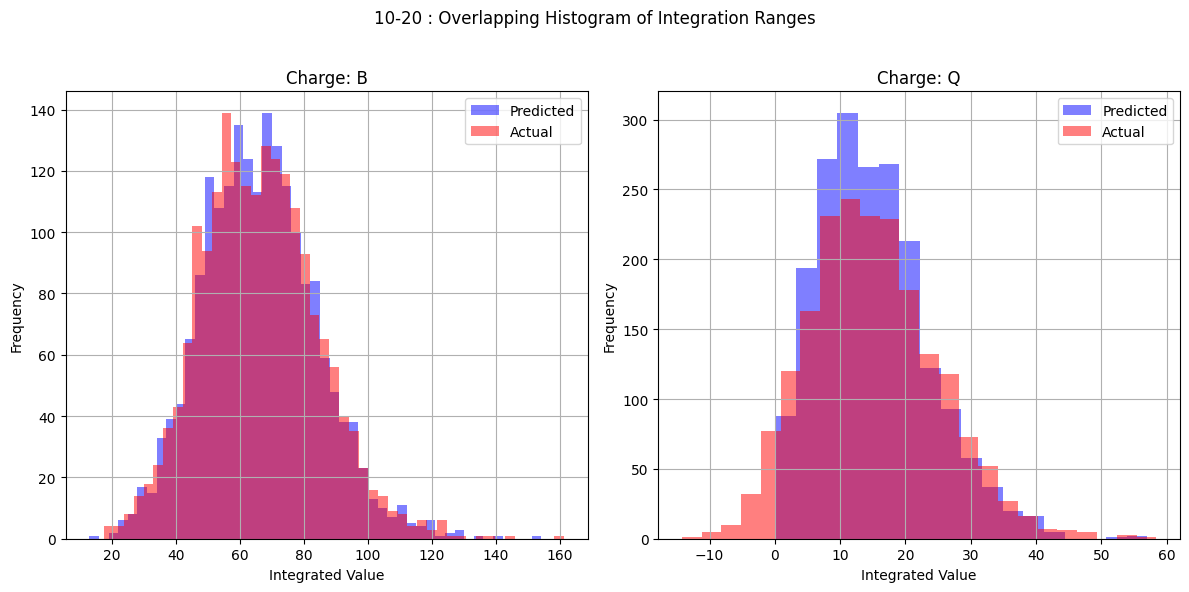

X_test: 31719
Check: 7641
0
actual 3906
pred 3906
1
actual 3991
pred 3991


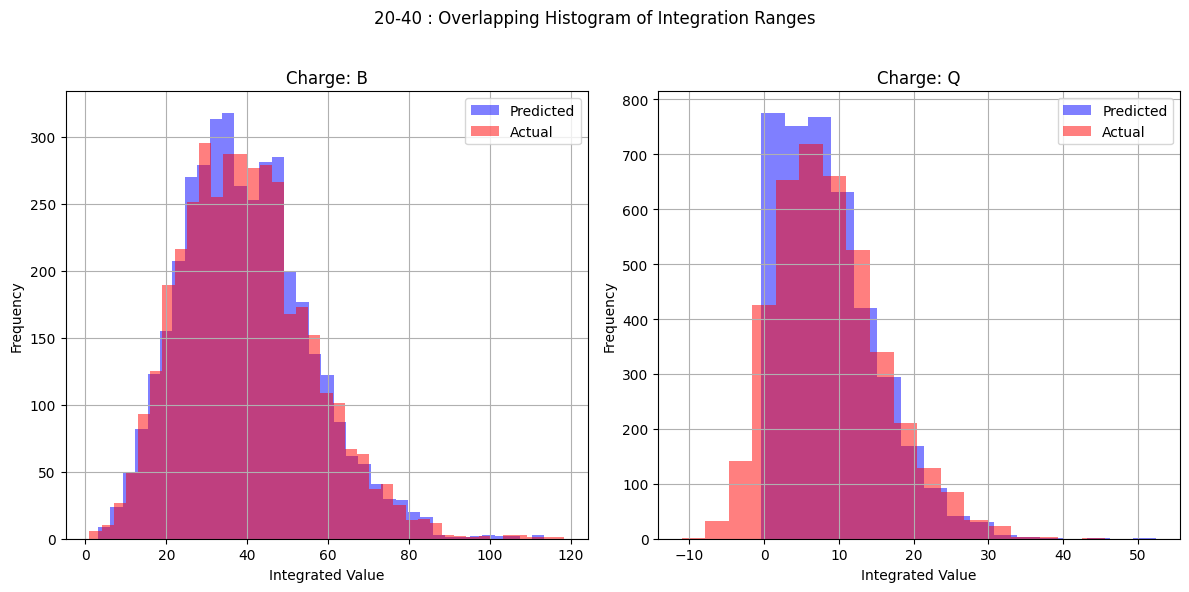

X_test: 31719
Check: 15538
0
actual 3985
pred 3985
1
actual 3998
pred 3998


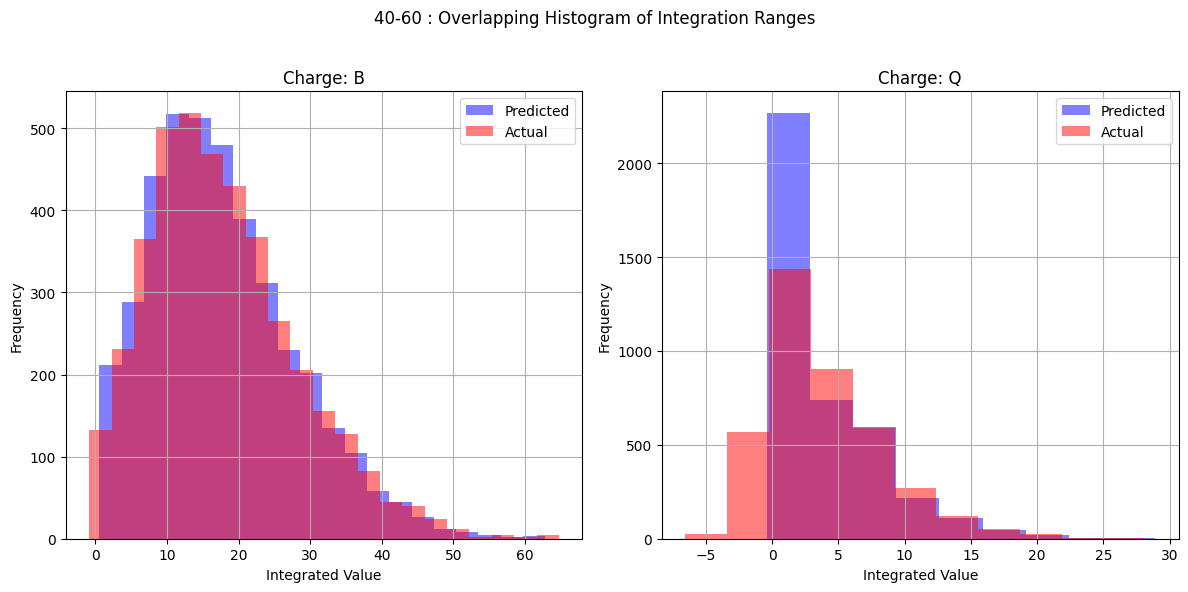

X_test: 31719
Check: 23521
0
actual 4124
pred 4124
1
actual 4074
pred 4074


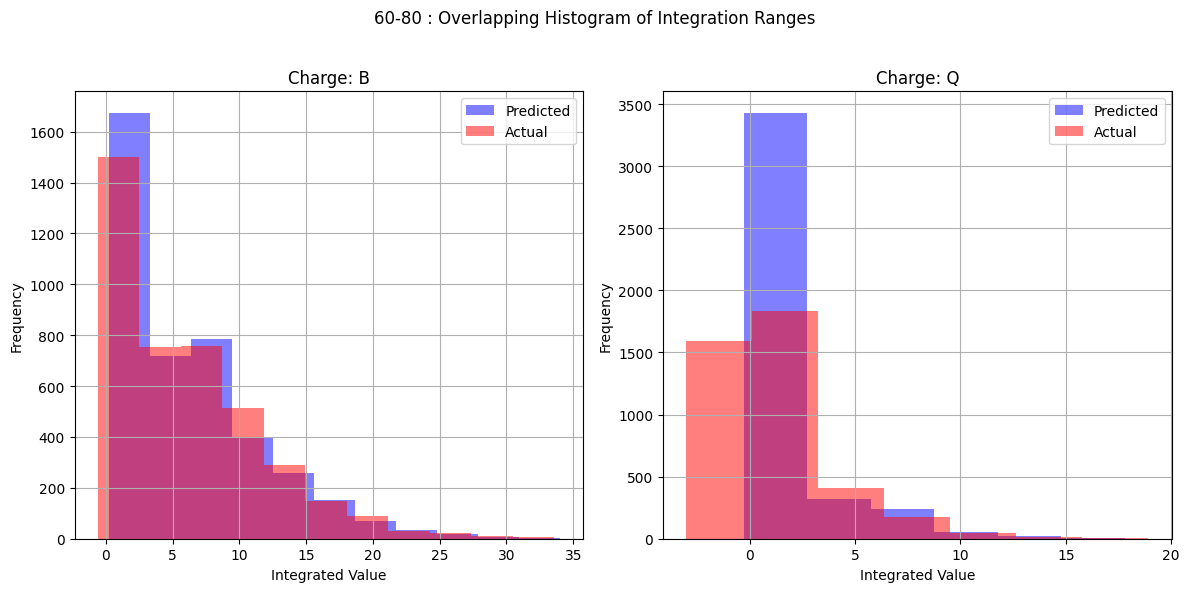

X_test: 31719
Check: 31719


In [40]:
plot_histograms(lr2, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

In [ ]:
plot_histograms(mlp_0, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

USING SAMPLES


In [ ]:
import numpy as np

# Initialize lists to store Yin, Yfin, Nuc, cent, and charge
all_Yin_sample = []
all_Yfin_sample = []
all_Nuc_sample = []
all_cent_sample = []
all_charge_sample = []

# Iterate through the dictionary
for Nuc, cent_dict in Data.items():
    for cent, charge_dict in cent_dict.items():
        if isinstance(charge_dict, dict):
            for charge, data_dict in charge_dict.items():
                if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                    # Load Xin, Yin, Xfin, Yfin using the load function
                    Xin, Yin, Xfin, Yfin = load_sample(Data, Nuc, cent, charge)
                    # Append to the lists along with identifiers
                    all_Yin_sample.append(Yin)
                    all_Yfin_sample.append(Yfin)
                    all_Nuc_sample.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                    all_cent_sample.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                    all_charge_sample.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_sample = np.concatenate(all_Yin_sample, axis=0)  # Assuming concatenation is appropriate
all_Yfin_sample = np.concatenate(all_Yfin_sample, axis=0)
all_Nuc_sample = np.array(all_Nuc_sample)
all_cent_sample = np.array(all_cent_sample)
all_charge_sample = np.array(all_charge_sample)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_sample.shape)
print("Shape of all_Yfin:", all_Yfin_sample.shape)
print("Shape of all_Nuc:", all_Nuc_sample.shape)
print("Shape of all_cent:", all_cent_sample.shape)
print("Shape of all_charge:", all_charge_sample.shape)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_sample = nuc_one_hot_encoder.fit_transform(all_Nuc_sample.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_sample = charge_one_hot_encoder.fit_transform(all_charge_sample.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_sample = cent_one_hot_encoder.fit_transform(all_cent_sample.reshape(-1, 1))


# Concatenate features
X_features_sample = np.concatenate([all_Yin_sample, 
                             all_Nuc_encoded_sample,
                             all_charge_encoded_sample], axis=1)

# Split data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2, all_cent_train_2, all_cent_test_2, all_charge_train_2, all_charge_test_2 = train_test_split(
    X_features_sample, all_Yfin_sample, all_cent_encoded_sample, all_charge_encoded_sample, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
lr2_sample = LinearRegression()
finetune(lr2_sample, X_train_2, y_train_2, X_test_2, y_test_2)

In [ ]:
plot_histograms(lr2_sample, X_test_2, y_test_2, all_cent_test_2, all_charge_test_2)

SCALED Y

In [ ]:
print(len(X_train_1))
print(len(y_train_1))

In [ ]:
print(y_train_1.shape)
print(y_train_1.reshape(-1, 1).shape)


126873
126873
Training completed in 1.80 seconds.
Mean Squared Error: 0.22443924311117344


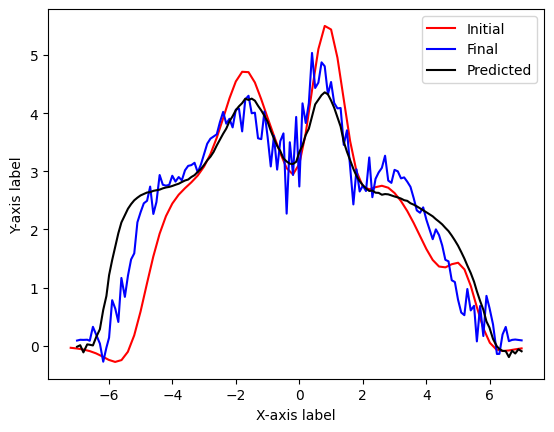

In [42]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance for X
scaler_X = StandardScaler()

# Fit the scaler to the 'all_Yin' feature in the training data and transform it
all_Yin_train_scaled = scaler_X.fit_transform(X_train_1[:, :72])  

# Use the same scaler to transform the 'all_Yin' feature in the test data
all_Yin_test_scaled = scaler_X.transform(X_test_1[:, :72])  

# Concatenate scaled 'all_Yin' with the encoded categorical features
X_train_scaled = np.concatenate([all_Yin_train_scaled, X_train_1[:, 72:]], axis=1)
X_test_scaled = np.concatenate([all_Yin_test_scaled, X_test_1[:, 72:]], axis=1)

# Create a StandardScaler instance for y
scaler_y = StandardScaler()

# Fit the scaler to the target variable in the training data and transform it
y_train_scaled = scaler_y.fit_transform(y_train_1)

# Use the same scaler to transform the target variable in the test data
y_test_scaled = scaler_y.transform(y_test_1)
print(len(X_train_scaled))
print(len(y_train_scaled))


model = LinearRegression()
finetune(model, X_train_scaled,y_train_scaled, X_test_scaled , y_test_scaled)
y_pred_scaled = model.predict(X_test_scaled)

# Use inverse_transform to scale the predictions back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Use inverse_transform to scale the features back to the original scale
X_test_orig = np.concatenate([scaler_X.inverse_transform(X_test_scaled[:, :72]), X_test_scaled[:, 72:]], axis=1)


0
actual 1909
pred 1909
1
actual 1823
pred 1823


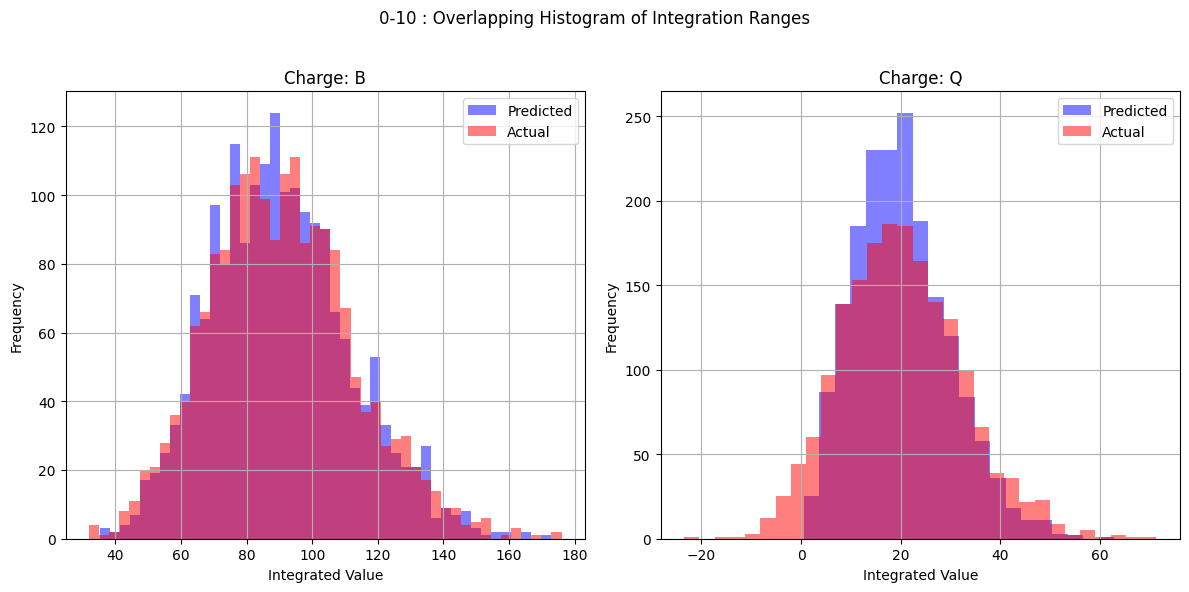

X_test: 31719
Check: 3732
0
actual 1949
pred 1949
1
actual 1960
pred 1960


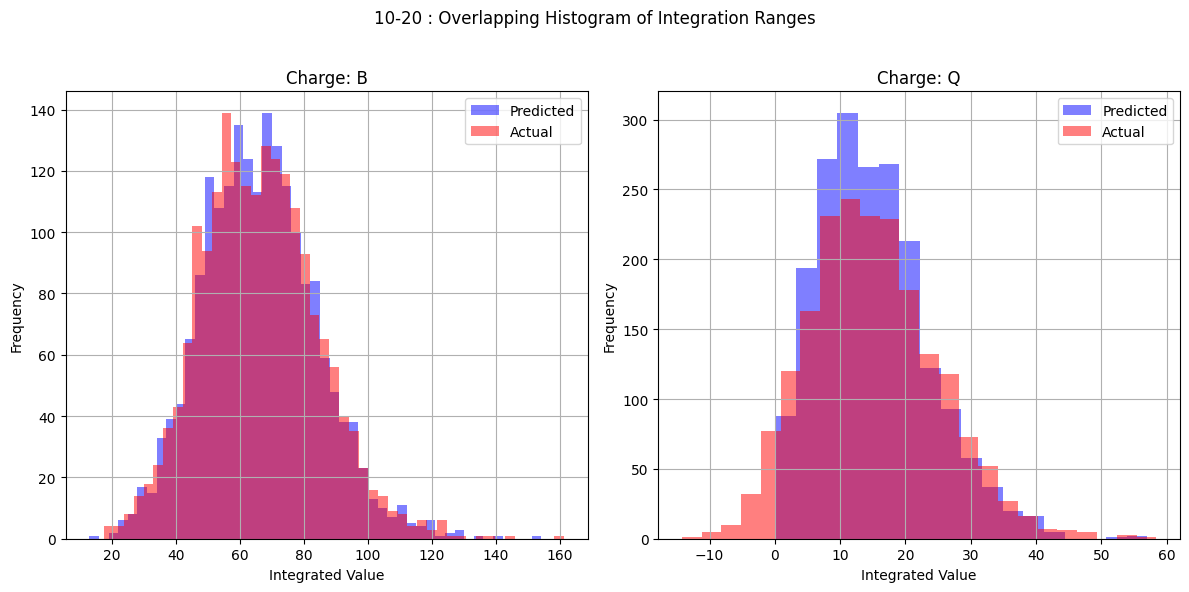

X_test: 31719
Check: 7641
0
actual 3906
pred 3906
1
actual 3991
pred 3991


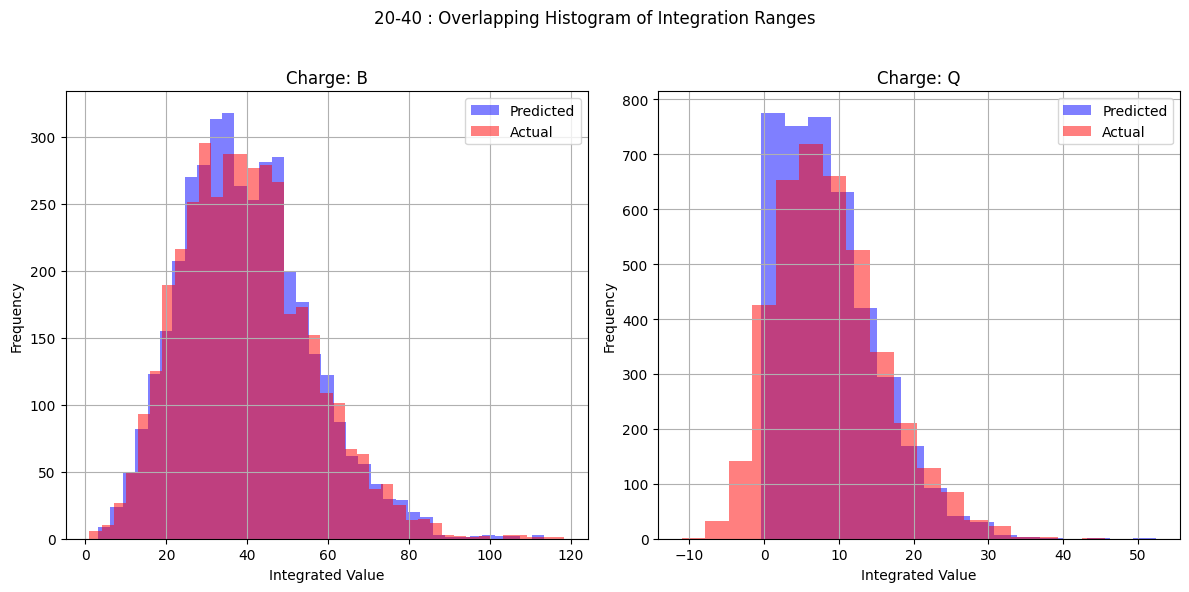

X_test: 31719
Check: 15538
0
actual 3985
pred 3985
1
actual 3998
pred 3998


In [ ]:
plot_histograms2(model, X_test_scaled, y_test_scaled, all_cent_test_1, all_charge_test_1)

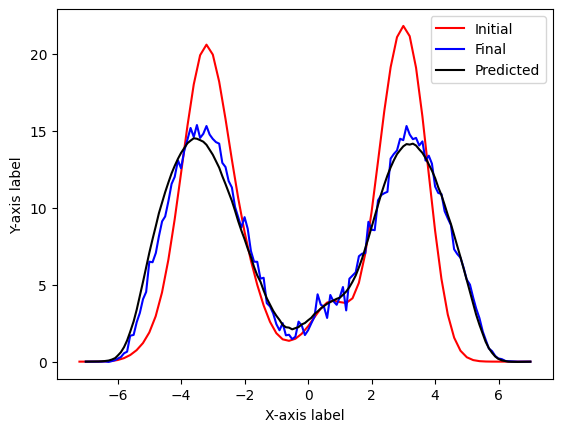

In [57]:
# Example plot (adjust as per your specific data and visualization needs)
sample_index = np.random.randint(1, len(X_test_scaled))
y1_plot = scaler_X.inverse_transform(X_test_scaled[sample_index, :72].reshape(1, -1))  # First 72 features are all_Yin
y1 = X_test_scaled[sample_index]
y2 = ([y_test_scaled[sample_index]])  # Corresponding y_test value

# Example x-axis values
if y1[-2] == 0.0:
    xaxes1 = Xin_Ru
    xaxes2 = Xfin_Ru
else:
    xaxes1 = Xin_Zr
    xaxes2 = Xfin_Zr
flag = False
if flag:
    y1 = y1[:72]
    y2_pred_scaled = model.predict([y1])[0]
else:
    y2_pred_scaled = model.predict([y1])[0]

# Scale the predictions back to the original scale
y2_pred = scaler_y.inverse_transform([y2_pred_scaled])
# Convert the list to a numpy array before reshaping
y2 = scaler_y.inverse_transform(np.array([y2]).reshape(1, -1)) 
 
# Plotting
plt.plot(xaxes1, y1_plot[0], 'r', label='Initial')
plt.plot(xaxes2, y2[0], 'b', label='Final')
plt.plot(xaxes2, y2_pred[0], 'k', label='Predicted')
plt.legend()
plt.xlabel('X-axis label')  # Replace with your actual x-axis label
plt.ylabel('Y-axis label')  # Replace with your actual y-axis label
plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for histograms
def plot_histograms2(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels

    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)

    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred_scaled = model.predict([y1])

                # Scale the predictions back to the original scale
                y2_pred = scaler_y.inverse_transform(y2_pred_scaled)
                y2 = scaler_y.inverse_transform(np.array([y2]).reshape(1, -1)) 
                # Flatten y2 to a 1D array
                y2 = y2.flatten()


                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)
                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 0.5 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)


In [47]:
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def finetune2(model, X_train, y_train, X_test, y_test, flag=False, scale=False):
    start_time = time.time()
    
    # Create a StandardScaler instance for X and y
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    if scale == True:
        # Fit the scaler to the 'all_Yin' feature in the training data and transform it
        all_Yin_train_scaled = scaler_X.fit_transform(X_train[:, :72]) 

        # Use the same scaler to transform the 'all_Yin' feature in the test data
        all_Yin_test_scaled = scaler_X.transform(X_test[:, :72])  

        # Concatenate scaled 'all_Yin' with the encoded categorical features
        X_train = np.concatenate([all_Yin_train_scaled, X_train[:, 72:]], axis=1)
        X_test = np.concatenate([all_Yin_test_scaled, X_test[:, 72:]], axis=1)

        # Scale y_train and y_test
        y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler_y.transform(y_test.reshape(-1, 1))

    if flag:
        # Train the model using only the first 72 features
        model.fit(X_train[:, :72], y_train)
        # Predict on test data using only the first 72 features
        y_pred = model.predict(X_test[:, :72])
    else:
        # Train the model on all features
        model.fit(X_train, y_train)
        # Predict on test data using all features
        y_pred = model.predict(X_test)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Example plot (adjust as per your specific data and visualization needs)
    sample_index = np.random.randint(1, len(X_test))
    y1_plot = scaler_X.inverse_transform(X_test[sample_index, :72].reshape(1, -1))  # First 72 features are all_Yin
    y1 = X_test[sample_index]
    y2 = scaler_y.inverse_transform(y_test[sample_index])  # Corresponding y_test value

    # Example x-axis values
    if y1[-2] == 0.0:
        xaxes1 = Xin_Ru
        xaxes2 = Xfin_Ru
    else:
        xaxes1 = Xin_Zr
        xaxes2 = Xfin_Zr

    if flag:
        y1 = y1[:72]
        y2_pred = model.predict([y1])[0]
    else:
        y2_pred = model.predict([y1])[0]

    # Inverse transform the predictions
    y2_pred = scaler_y.inverse_transform(y2_pred)

    # Plotting
    plt.plot(xaxes1, y1_plot[0], 'r', label='Initial')
    plt.plot(xaxes2, y2[0], 'b', label='Final')
    plt.plot(xaxes2, y2_pred[0], 'k', label='Predicted')
    plt.legend()
    plt.xlabel('X-axis label')  # Replace with your actual x-axis label
    plt.ylabel('Y-axis label')  # Replace with your actual y-axis label
    plt.show()


ONLY FOR Q

In [ ]:
import numpy as np

# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin = []
all_Yfin = []
all_Xin = []
all_Xfin = []
all_Nuc = []
all_cent = []
all_charge = []

# Iterate through the dictionary
for Data in Dcts:
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if charge == 'Q':
                        if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                            # Load Xin, Yin, Xfin, Yfin using the load function
                            Xin, Yin, Xfin, Yfin = load_sample(Data, Nuc, cent, charge)
                            # Append to the lists along with identifiers
                            all_Yin.append(Yin)
                            all_Yfin.append(Yfin)
                            all_Xin.append(Xin)
                            all_Xfin.append(Xfin)
                            all_Nuc.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                            all_cent.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                            all_charge.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_full = np.concatenate(all_Yin, axis=0)  # Assuming concatenation is appropriate
all_Yfin_full = np.concatenate(all_Yfin, axis=0)
all_Nuc_full = np.array(all_Nuc)
all_cent_full = np.array(all_cent)
all_charge_full = np.array(all_charge)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_full.shape)
print("Shape of all_Yfin:", all_Yfin_full.shape)
print("Shape of all_Nuc:", all_Nuc_full.shape)
print("Shape of all_cent:", all_cent_full.shape)
print("Shape of all_charge:", all_charge_full.shape)

from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_full = nuc_one_hot_encoder.fit_transform(all_Nuc_full.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_full = charge_one_hot_encoder.fit_transform(all_charge_full.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_full = cent_one_hot_encoder.fit_transform(all_cent_full.reshape(-1, 1))

# Concatenate features
X_features = np.concatenate([all_Yin_full, all_Nuc_encoded_full, all_charge_encoded_full], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1, all_cent_train_1, all_cent_test_1, all_charge_train_1, all_charge_test_1 = train_test_split(
    X_features, all_Yfin_full, all_cent_encoded_full, all_charge_encoded_full, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
lr2_sample = LinearRegression()
finetune(lr2_sample, X_train_1, y_train_1, X_test_1, y_test_1)

In [59]:
plot_histograms2(lr2_sample, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

NameError: name 'lr2_sample' is not defined

In [ ]:
mlp2 = MLPRegressor(hidden_layer_sizes=(100), max_iter=400, random_state=42)
finetune(mlp2, X_train_1, y_train_1, X_test_1, y_test_1)

In [ ]:
plot_histograms2(mlp2, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

In [ ]:
data_path_2 = '/kaggle/input/lqns-dict-batch-1/LQNS_dict_batch_1.dat'
with open(data_path_2, "rb") as pf:
    Data2 = pickle.load(pf)

In [ ]:
Dcts.append(Data2)

In [ ]:
import numpy as np

# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin = []
all_Yfin = []
all_Xin = []
all_Xfin = []
all_Nuc = []
all_cent = []
all_charge = []

for Data in Dcts:
    # Iterate through the dictionary
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                        # Load Xin, Yin, Xfin, Yfin using the load function
                        Xin, Yin, Xfin, Yfin = load(Data, Nuc, cent, charge)
                        # Append to the lists along with identifiers
                        all_Yin.append(Yin)
                        all_Yfin.append(Yfin)
                        all_Xin.append(Xin)
                        all_Xfin.append(Xfin)
                        all_Nuc.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                        all_cent.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                        all_charge.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_full = np.concatenate(all_Yin, axis=0)  # Assuming concatenation is appropriate
all_Yfin_full = np.concatenate(all_Yfin, axis=0)
all_Nuc_full = np.array(all_Nuc)
all_cent_full = np.array(all_cent)
all_charge_full = np.array(all_charge)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_full.shape)
print("Shape of all_Yfin:", all_Yfin_full.shape)
print("Shape of all_Nuc:", all_Nuc_full.shape)
print("Shape of all_cent:", all_cent_full.shape)
print("Shape of all_charge:", all_charge_full.shape)

from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_full = nuc_one_hot_encoder.fit_transform(all_Nuc_full.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_full = charge_one_hot_encoder.fit_transform(all_charge_full.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_full = cent_one_hot_encoder.fit_transform(all_cent_full.reshape(-1, 1))

# Concatenate features
X_features = np.concatenate([all_Yin_full, all_Nuc_encoded_full, all_charge_encoded_full], axis=1)



In [ ]:
len(lr2.predict(X_features))